In [1]:
import os
import time
import io
import struct
import sys
import math

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
infile = 'giphy.gif'
os.path.exists(infile)

True

In [4]:
file_obj = open(infile, mode='rb')

In [5]:
# file_obj.close()

# Compare signature

In [6]:
sig = file_obj.read(6)
sig

b'GIF89a'

In [7]:
len(sig)

6

In [8]:
type(sig)

bytes

In [9]:
gif87a_sig = b'GIF87a'
gif89a_sig = b'GIF89a'

In [10]:
msg = f'Hi {str(gif89a_sig)}'
print(msg)

Hi b'GIF89a'


In [11]:
type(gif89a_sig)

bytes

In [12]:
gif89a_sig

b'GIF89a'

In [13]:
sig == gif89a_sig

True

In [14]:
sig == gif87a_sig

False

# Screen Descriptor

In [15]:
screen_desc = file_obj.read(7)

In [16]:
len(screen_desc)

7

In [17]:
type(screen_desc)

bytes

In [18]:
width = struct.unpack('<h', screen_desc[0:2])[0]
height = struct.unpack('<h', screen_desc[2:4])[0]
packed_field = screen_desc[4]
background_color_index = screen_desc[5]
# Pixel Aspect Ratio is normal not used because we've known the width and height.
# pixel_aspect_ratio = screen_desc[6]

## unpack Packed Fields

In [19]:
packed_field

246

In [20]:
type(packed_field)

int

In [21]:
bin(packed_field)

'0b11110110'

In [22]:
global_color_table_flag = (packed_field & 0b10000000) >> 7
global_color_table_flag, bin(global_color_table_flag)

(1, '0b1')

> Color Resolution - Number of bits per primary color available to the original image, minus 1.

I think that means the number of bits to store a color. E.g. true color (RGB) requires 24 bits (3 bytes). Yeah, it makes no sense to me right now because the maximum value for this field is 7 (3 bits all 1).

> This value represents the size of the entire palette from which the colors in the graphic were selected, not the number of colors actually used in the graphic.

I still have no sense what the specification is talking about. The maximum value for this field is 7 so the maximum size of the palette is 7 something?

> For example, if the value in this field is 3, then the palette of the original image had 4 bits per primary color available to create the image.

Now I am noticing the specification is meaning about `original image`. Are there multiple images out there we need to care about outside the image this GIF file is storing? Even you raise the maximum value to 8, we can't still store a RGB color format in 8 bits.

> This value should be set to indicate the richness of the original palette, even if not every color from the whole palette is available on the source machine.

No, that does help at all. Specification!!!

In [23]:
color_resolution = (packed_field & 0b01110000) >> 4
color_resolution, bin(color_resolution)

(7, '0b111')

> Sort Flag - Indicates whether the Global Color Table is sorted.

Simple enough.

> If the flag is set, the Global Color Table is sorted, in order of decreasing importance. Typically, the order would be descreasing frequency, with most frequent color first. This assists a decoder, with fewer available colors, in choosing the best subset of colors; the decoder may use an initial segment of the table to render the graphic.

Yeah, I think I got that.

In [24]:
sort_flag = (packed_field & 0b00001000) >> 3
sort_flag, bin(sort_flag)

(0, '0b0')

> Size of Global Color Table - If the Global Color Table Flag is set to 1, the value in this field is used to calculate the number of bytes contained in the Global Color Table. To determine that actual size of the color table, raise 2 to [the value of the field + 1].

The size of global table is `(field_value + 1) * 2)` bytes, isn't it? So the maximum size for global palette is 16 bytes. Huh, 16 colors or 16 bytes to store color values?

> Even if there is not Global Color Table specified, set this field according to the above formula so that decoders can choose the best graphics mode to display the stream in.

How the size of the palette related to the graphics mode?

In [25]:
global_color_table_size = (packed_field & 0b00000111) >> 0
global_color_table_size, bin(global_color_table_size)

(6, '0b110')

In [26]:
global_palette_num_bytes = 3 * (2**(global_color_table_size+1))
global_palette_num_bytes

384

# Global palette (if the flag is set)

In [27]:
global_palette_data = file_obj.read(global_palette_num_bytes)
len(global_palette_data)

384

In [28]:
global_palette_data[0]

35

In [29]:
global_palette = [[*global_palette_data[i:i+3]] for i in range(0, len(global_palette_data), 3)]
len(global_palette)

128

In [30]:
global_palette

[[35, 33, 35],
 [53, 43, 42],
 [39, 51, 63],
 [61, 55, 58],
 [85, 58, 53],
 [27, 55, 85],
 [39, 57, 80],
 [59, 67, 79],
 [56, 72, 95],
 [28, 66, 105],
 [40, 69, 100],
 [62, 81, 102],
 [42, 81, 121],
 [56, 84, 120],
 [83, 68, 67],
 [83, 79, 80],
 [104, 69, 65],
 [110, 79, 71],
 [125, 83, 76],
 [101, 85, 87],
 [127, 92, 82],
 [80, 84, 97],
 [90, 93, 103],
 [71, 93, 112],
 [90, 100, 111],
 [95, 108, 115],
 [86, 101, 126],
 [111, 98, 100],
 [113, 109, 112],
 [109, 113, 126],
 [129, 106, 102],
 [154, 106, 98],
 [144, 119, 110],
 [128, 119, 122],
 [143, 123, 127],
 [164, 121, 114],
 [153, 161, 4],
 [164, 172, 4],
 [196, 198, 4],
 [236, 234, 4],
 [189, 128, 122],
 [211, 132, 124],
 [51, 92, 134],
 [63, 104, 150],
 [48, 101, 161],
 [49, 109, 170],
 [57, 121, 179],
 [67, 97, 131],
 [74, 107, 137],
 [89, 111, 134],
 [71, 112, 155],
 [90, 123, 158],
 [96, 120, 137],
 [112, 124, 133],
 [75, 121, 167],
 [110, 129, 150],
 [112, 137, 156],
 [76, 129, 189],
 [86, 128, 178],
 [99, 135, 163],
 [110, 141

In [31]:
def show_palette(palette):
    palette_width = 16
    
    image = []
    row = []
    for i, rgb in enumerate(palette):
        row.append(rgb)
        
        if (i > 0) and ((i+1) % palette_width == 0):
            image.append(row)
            row = []
#     print(image)
#     print(len(image))
    plt.imshow(image)
    plt.show()

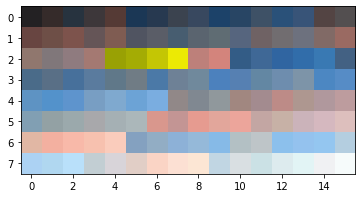

In [32]:
show_palette(global_palette)

# Next is unknown block type

Read the first byte to identify which type of block

In [33]:
block_identifier = file_obj.read(1)[0]
block_identifier, hex(block_identifier), bin(block_identifier)

(33, '0x21', '0b100001')

All extension blocks begin with `21`.

## Types of extension block

| extension label (the next byte value) | block type |
|---|---|
| 0xFF | Application Extension |
| 0x01 | Plain Text Extension |
| 0xFE | Comment Extension |
| 0xF9 | Graphic Control Extension |

In [34]:
# GIF_TRAILER = 0x3b
# GIF_EXTENSION_INTRODUCER = 0x21
# GIF_IMAGE_SEPARATOR = 0x2c
# GIF_GCE_EXT_LABEL = 0xf9
# GIF_COM_EXT_LABEL = 0xfe
# GFI_APP_EXT_LEBEL = 0xff

# def process_gif_blocks(file_obj: io.BufferedReader):
#     while True:
#         block_type = file_obj.read(1)
#         if len(block_type) == 0:
#             # end of file
#             break
        
#         block_type = block_type[0]

In [44]:
file_obj.tell()

402

In [43]:
bs = file_obj.read(1)
type(bs), len(bs), bs

(bytes, 1, b'\n')

# Image Descriptor

In [37]:
# image_descriptor = file_obj.read(1) # 10 bytes

In [38]:
# image_separator = image_descriptor[0]
# image_separator, hex(image_separator), bin(image_separator)